In [3]:
# coding: utf8
#!/usr/bin/env python
# ------------------------------------------------------------------------
# Carte de Kohonen
# Écrit par Mathieu Lefort
#
# Distribué sous licence BSD.
# ------------------------------------------------------------------------
# Implémentation de l'algorithme des cartes auto-organisatrices de Kohonen
# ------------------------------------------------------------------------
# Pour que les divisions soient toutes réelles (pas de division entière)
from __future__ import division
# Librairie de calcul matriciel
import numpy
# Librairie d'affichage
import matplotlib.pyplot as plt
import os

In [4]:
class Neuron:
  ''' Classe représentant un neurone '''
  
  def __init__(self, w, posx, posy):
    '''
    @summary: Création d'un neurone
    @param w: poids du neurone
    @type w: numpy array
    @param posx: position en x du neurone dans la carte
    @type posx: int
    @param posy: position en y du neurone dans la carte
    @type posy: int
    '''
    # Initialisation des poids
    self.weights = w.flatten()
    # Initialisation de la position
    self.posx = posx
    self.posy = posy
    # Initialisation de la sortie du neurone
    self.y = 0.
  
  def compute(self,x):
    '''
    @summary: Affecte à y la valeur de sortie du neurone (ici on choisit la distance entre son poids et l'entrée, i.e. une fonction d'aggrégation identité)
    @param x: entrée du neurone
    @type x: numpy array
    '''
    # On calcule la distance entre le poids du neurone et l'entrée
    self.y = numpy.linalg.norm(self.weights - x.flatten())

  def learn(self,eta,sigma,posxjetoile,posyjetoile,x):
    '''
    @summary: Modifie les poids selon la règle de Kohonen
    @param eta: taux d'apprentissage
    @type eta: float
    @param sigma: largeur du voisinage
    @type sigma: float
    @param posxjetoile: position en x du neurone gagnant (i.e. celui dont le poids est le plus proche de l'entrée)
    @type posxjetoile: int
    @param posyjetoile: position en y du neurone gagnant (i.e. celui dont le poids est le plus proche de l'entrée)
    @type posyjetoile: int
    @param x: entrée du neurone
    @type x: numpy array
    '''
    # Calcul de la distance entre le neurone et le neurone gagnant
    dist = (self.posx - posxjetoile)**2 + (self.posy - posyjetoile)**2
    h = numpy.exp(-dist / (2 * sigma * sigma))
    self.weights[:] = self.weights[:] + eta * h * (x.flatten() - self.weights)

In [5]:
class SOM:
  ''' Classe implémentant une carte de Kohonen. '''

  def __init__(self, inputsize, gridsize):
    '''
    @summary: Création du réseau
    @param inputsize: taille de l'entrée
    @type inputsize: tuple
    @param gridsize: taille de la carte
    @type gridsize: tuple
    '''
    # Initialisation de la taille de l'entrée
    self.inputsize = inputsize
    # Initialisation de la taille de la carte
    self.gridsize = gridsize
    # Création de la carte
    # Carte de neurones
    self.map = []    
    # Carte des poids
    self.weightsmap = []
    # Carte des activités
    self.activitymap = []
    for posx in range(gridsize[0]):
      mline = []
      wmline = []
      amline = []
      for posy in range(gridsize[1]):
        neuron = Neuron(numpy.random.random(self.inputsize),posx,posy)
        mline.append(neuron)
        wmline.append(neuron.weights)
        amline.append(neuron.y)
      self.map.append(mline)
      self.weightsmap.append(wmline)
      self.activitymap.append(amline)
    self.activitymap = numpy.array(self.activitymap)

  def compute(self,x):
    '''
    @summary: calcule de l'activité des neurones de la carte
    @param x: entrée de la carte (identique pour chaque neurone)
    @type x: numpy array
    '''
    # On demande à chaque neurone de calculer son activité et on met à jour la carte d'activité de la carte
    for posx in range(self.gridsize[0]):
      for posy in range(self.gridsize[1]):
        self.map[posx][posy].compute(x)
        self.activitymap[posx][posy] = self.map[posx][posy].y

  def learn(self,eta,sigma,x):
    '''
    @summary: Modifie les poids de la carte selon la règle de Kohonen
    @param eta: taux d'apprentissage
    @type eta: float
    @param sigma: largeur du voisinage
    @type sigma: float
    @param x: entrée de la carte
    @type x: numpy array
    '''
    # Calcul du neurone vainqueur
    jetoilex,jetoiley = numpy.unravel_index(numpy.argmin(self.activitymap),self.gridsize)
    # Mise à jour des poids de chaque neurone
    for posx in range(self.gridsize[0]):
      for posy in range(self.gridsize[1]):
        self.map[posx][posy].learn(eta,sigma,jetoilex,jetoiley,x)

        
      

  def scatter_plot(self,interactive=False):
    '''
    @summary: Affichage du réseau dans l'espace d'entrée (utilisable dans le cas d'entrée à deux dimensions et d'une carte avec une topologie de grille carrée)
    @param interactive: Indique si l'affichage se fait en mode interactif
    @type interactive: boolean
    '''
    # Création de la figure
    if not interactive:
      plt.figure()
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Affichage des poids
    plt.scatter(w[:,:,0].flatten(),w[:,:,1].flatten(),c='k')
    # Affichage de la grille
    for i in range(w.shape[0]):
      plt.plot(w[i,:,0],w[i,:,1],'k',linewidth=1.)
    for i in range(w.shape[1]):
      plt.plot(w[:,i,0],w[:,i,1],'k',linewidth=1.)
    # Modification des limites de l'affichage
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    # Affichage du titre de la figure
    plt.suptitle('Poids dans l\'espace d\'entree')
    # Affichage de la figure
    if not interactive:
      plt.show()

  def scatter_plot_2(self,interactive=False):
    '''
    @summary: Affichage du réseau dans l'espace d'entrée en 2 fois 2d (utilisable dans le cas d'entrée à quatre dimensions et d'une carte avec une topologie de grille carrée)
    @param interactive: Indique si l'affichage se fait en mode interactif
    @type interactive: boolean
    '''
    # Création de la figure
    if not interactive:
      plt.figure()
    # Affichage des 2 premières dimensions dans le plan
    plt.subplot(1,2,1)
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Affichage des poids
    plt.scatter(w[:,:,0].flatten(),w[:,:,1].flatten(),c='k')
    # Affichage de la grille
    for i in range(w.shape[0]):
      plt.plot(w[i,:,0],w[i,:,1],'k',linewidth=1.)
    for i in range(w.shape[1]):
      plt.plot(w[:,i,0],w[:,i,1],'k',linewidth=1.)
    # Affichage des 2 dernières dimensions dans le plan
    plt.subplot(1,2,2)
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Affichage des poids
    plt.scatter(w[:,:,2].flatten(),w[:,:,3].flatten(),c='k')
    # Affichage de la grille
    for i in range(w.shape[0]):
      plt.plot(w[i,:,2],w[i,:,3],'k',linewidth=1.)
    for i in range(w.shape[1]):
      plt.plot(w[:,i,2],w[:,i,3],'k',linewidth=1.)
    # Affichage du titre de la figure
    plt.suptitle('Poids dans l\'espace d\'entree')
    # Affichage de la figure
    if not interactive:
      plt.show()

  def plot(self):
    '''
    @summary: Affichage des poids du réseau (matrice des poids)
    '''
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Création de la figure
    f,a = plt.subplots(w.shape[0],w.shape[1])    
    # Affichage des poids dans un sous graphique (suivant sa position de la SOM)
    for i in range(w.shape[0]):
      for j in range(w.shape[1]):
        plt.subplot(w.shape[0],w.shape[1],i*w.shape[1]+j+1)
        im = plt.imshow(w[i,j].reshape(self.inputsize),interpolation='nearest',vmin=numpy.min(w),vmax=numpy.max(w),cmap='binary')
        plt.xticks([])
        plt.yticks([])
    # Affichage de l'échelle
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax)
    # Affichage du titre de la figure
    plt.suptitle('Poids dans l\'espace de la carte')
    # Affichage de la figure
    plt.show()

  def quantification(self,X):
    '''
    @summary: Calcul de l'erreur de quantification vectorielle moyenne du réseau sur le jeu de données
    @param X: le jeu de données
    @type X: numpy array
    '''
    # On récupère le nombre d'exemples
    nsamples = X.shape[0]
    # Somme des erreurs quadratiques
    s = 0
    # Pour tous les exemples du jeu de test
    for x in X:
      # On calcule la distance à chaque poids de neurone
      self.compute(x.flatten())
      # On rajoute la distance minimale au carré à la somme
      s += numpy.min(self.activitymap)**2
    # On renvoie l'erreur de quantification vectorielle moyenne
    return s/nsamples

def distorsion_locale_moyenne(network):
    '''
    @summary: Calcule la distorsion locale moyenne entre neurones voisins
    @param network: une instance de SOM
    @return: valeur moyenne des distances entre les poids de neurones voisins
    '''
    w = numpy.array(network.weightsmap)
    total = 0
    count = 0
    for i in range(network.gridsize[0]):
        for j in range(network.gridsize[1]):
            current = w[i][j]
            # voisins droite et bas (pour éviter double comptage)
            if i + 1 < network.gridsize[0]:
                total += numpy.linalg.norm(current - w[i+1][j])**2
                count += 1
            if j + 1 < network.gridsize[1]:
                total += numpy.linalg.norm(current - w[i][j+1])**2
                count += 1
    return total / count

def compute_local_roughness(weight_grid):
    """
    Calcule la rugosité locale moyenne de la carte de poids.
    
    Paramètre :
        weight_grid (np.ndarray) : un tableau numpy de forme (height, width, dim),
                                   contenant les vecteurs de poids de chaque neurone.
        
    Retour :
        float : la rugosité moyenne de la carte.
    """
    height, width, dim = weight_grid.shape
    total_roughness = 0
    count = 0

    # Parcours de chaque neurone
    for i in range(height):
        for j in range(width):
            w_ij = weight_grid[i, j]
            neighbors = []

            # Voisins 4-connectés (haut, bas, gauche, droite)
            if i > 0: neighbors.append(weight_grid[i - 1, j])
            if i < height - 1: neighbors.append(weight_grid[i + 1, j])
            if j > 0: neighbors.append(weight_grid[i, j - 1])
            if j < width - 1: neighbors.append(weight_grid[i, j + 1])

            # Calcul des distances aux voisins
            for w_neighbor in neighbors:
                dist_sq = numpy.linalg.norm(w_ij - w_neighbor)**2
                total_roughness += dist_sq
                count += 1

    return total_roughness / count if count > 0 else 0


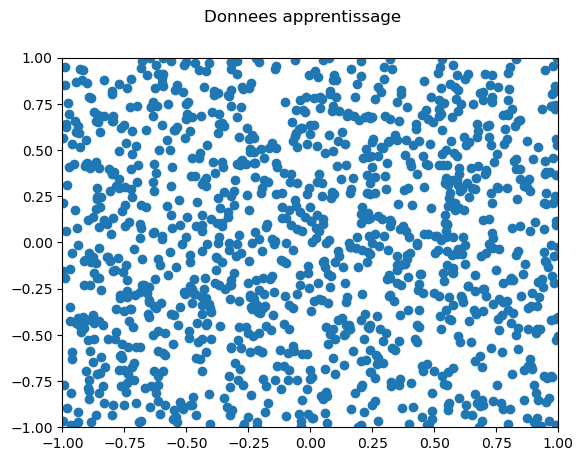

KeyboardInterrupt: 

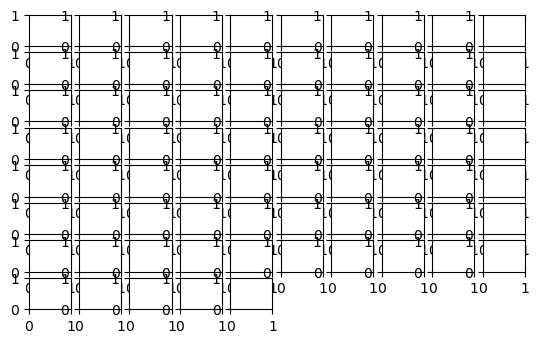

In [6]:

# -----------------------------------------------------------------------------
if __name__ == '__main__':
  # Création d'un réseau avec une entrée (2,1) et une carte (10,10)
  #TODO mettre à jour la taille des données d'entrée pour les données robotiques
  network = SOM((2,1),(10,10))
  # PARAMÈTRES DU RÉSEAU
  # Taux d'apprentissage
  ETA = 0.05
  # Largeur du voisinage
  SIGMA = 1.4
  # Nombre de pas de temps d'apprentissage
  N = 30000
  # Affichage interactif de l'évolution du réseau 
  #TODO à mettre à faux pour que les simulations aillent plus vite
  VERBOSE = True
  # Nombre de pas de temps avant rafraissichement de l'affichage
  NAFFICHAGE = 1000
  # DONNÉES D'APPRENTISSAGE
  # Nombre de données à générer pour les ensembles 1, 2 et 3
  # TODO décommenter les données souhaitées
  nsamples = 1200
  # Ensemble de données 1
  samples = numpy.random.random((nsamples,2,1))*2-1
  # Ensemble de données 2
#  samples1 = -numpy.random.random((nsamples//3,2,1))
#  samples2 = numpy.random.random((nsamples//3,2,1))
#  samples2[:,0,:] -= 1
#  samples3 = numpy.random.random((nsamples//3,2,1))
#  samples3[:,1,:] -= 1
#  samples = numpy.concatenate((samples1,samples2,samples3))
  # Ensemble de données 3
#  samples1 = numpy.random.random((nsamples//2,2,1))
#  samples1[:,0,:] -= 1
#  samples2 = numpy.random.random((nsamples//2,2,1))
#  samples2[:,1,:] -= 1
#  samples = numpy.concatenate((samples1,samples2))
  # Ensemble de données robotiques
#  samples = numpy.random.random((nsamples,4,1))
#  samples[:,0:2,:] *= numpy.pi
#  l1 = 0.7
#  l2 = 0.3
#  samples[:,2,:] = l1*numpy.cos(samples[:,0,:])+l2*numpy.cos(samples[:,0,:]+samples[:,1,:])
#  samples[:,3,:] = l1*numpy.sin(samples[:,0,:])+l2*numpy.sin(samples[:,0,:]+samples[:,1,:])
  # Affichage des données (pour les ensembles 1, 2 et 3)
  plt.figure()
  plt.scatter(samples[:,0,0], samples[:,1,0])
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.suptitle('Donnees apprentissage')
  plt.show()

  dossier = "ETA = " + str(ETA) + " SIGMA = " + str(SIGMA) + " N = " + str(N) + "NAFFICHAGE = " + str(NAFFICHAGE)
  path = os.path.join(r"C:\Users\amaur\Documents\Amaury Polytech\Semestre 8\ia\TP_1\Tests", dossier)
  if not os.path.exists(path):
      os.makedirs(path)
  # Affichage des données (pour l'ensemble robotique)
#  plt.figure()
#  plt.subplot(1,2,1)
#  plt.scatter(samples[:,0,0].flatten(),samples[:,1,0].flatten(),c='k')
#  plt.subplot(1,2,2)
#  plt.scatter(samples[:,2,0].flatten(),samples[:,3,0].flatten(),c='k')
#  plt.suptitle('Donnees apprentissage')
#  plt.show()
    
  # SIMULATION
  # Affichage des poids du réseau
  network.plot()
  # Initialisation de l'affichage interactif
  if VERBOSE:
    # Création d'une figure
    plt.figure()
    # Mode interactif
    plt.ion()
    # Affichage de la figure
    plt.show()
  else:
  	# Affichage de la grille initiale
  	network.scatter_plot(False)
  # Boucle d'apprentissage
  for i in range(N+1):
    # Choix d'un exemple aléatoire pour l'entrée courante
    index = numpy.random.randint(nsamples)
    x = samples[index].flatten()
    # Calcul de l'activité du réseau
    network.compute(x)
    # Modification des poids du réseau
    network.learn(ETA,SIGMA,x)
    # Mise à jour de l'affichage
    if VERBOSE and i%NAFFICHAGE==0:
      # Effacement du contenu de la figure
      plt.clf()
      # Remplissage de la figure
      # TODO à remplacer par scatter_plot_2 pour les données robotiques
      network.scatter_plot(True)
      # Affichage du contenu de la figure
      plt.pause(0.00001)
      plt.draw()
  # Fin de l'affichage interactif
  if VERBOSE:
    # Désactivation du mode interactif
    plt.ioff()
  else:
  	# Affichage de la grille finale
  	network.scatter_plot(False)
  # Affichage des poids du réseau
  network.plot()
  # Affichage de l'erreur de quantification vectorielle moyenne après apprentissage
  print("erreur de quantification vectorielle moyenne ",network.quantification(samples))
  print("distorsion locale moyenne ",distorsion_locale_moyenne(network))
  print("rugosite locale moyenne ",compute_local_roughness(numpy.array(network.weightsmap)))

def carte_de_chaleur_distorsion(network):
    '''
    @summary: Affiche une carte de chaleur des différences locales entre poids de neurones voisins
    '''
    w = numpy.array(network.weightsmap)
    heatmap = numpy.zeros((network.gridsize[0], network.gridsize[1]))
    for i in range(network.gridsize[0]):
        for j in range(network.gridsize[1]):
            dist = 0
            count = 0
            if i > 0:
                dist += numpy.linalg.norm(w[i][j] - w[i-1][j])**2
                count += 1
            if i < network.gridsize[0] - 1:
                dist += numpy.linalg.norm(w[i][j] - w[i+1][j])**2
                count += 1
            if j > 0:
                dist += numpy.linalg.norm(w[i][j] - w[i][j-1])**2
                count += 1
            if j < network.gridsize[1] - 1:
                dist += numpy.linalg.norm(w[i][j] - w[i][j+1])**2
                count += 1
            heatmap[i][j] = dist / count if count > 0 else 0
    plt.figure()
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Carte de chaleur des distorsions locales")
    plt.show()







carte_de_chaleur_distorsion(network)


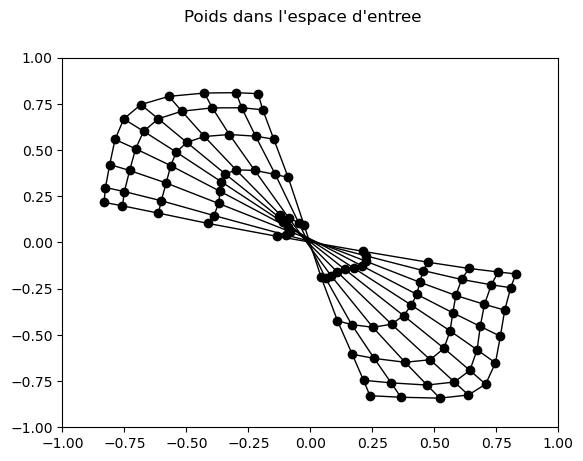

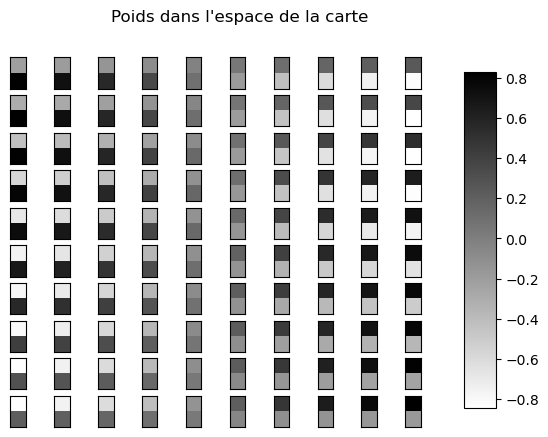

N: 20000
Erreur de quantification vectorielle moyenne: 0.011976640935097059
Distorsion locale moyenne: 0.029473593206574587
Rugosité locale moyenne: 0.029473593206574587


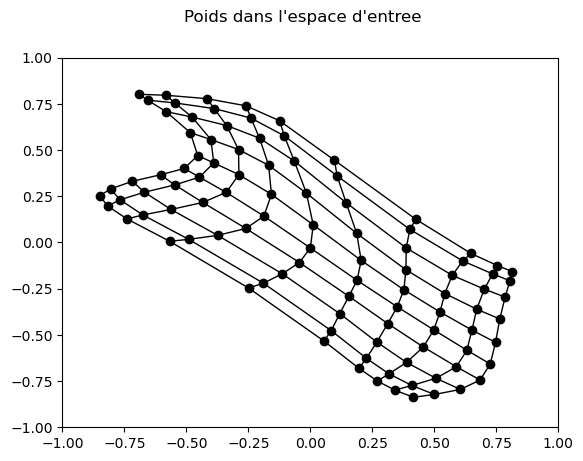

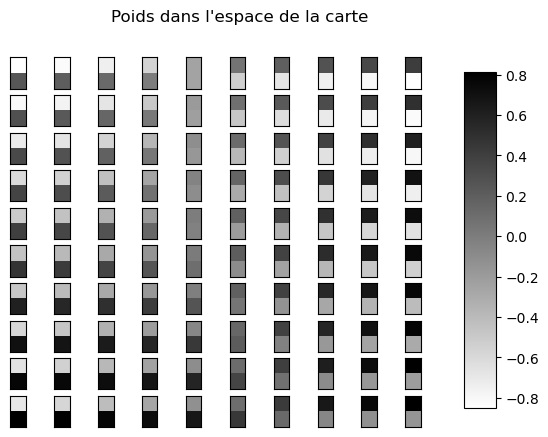

N: 30000
Erreur de quantification vectorielle moyenne: 0.014242647751709707
Distorsion locale moyenne: 0.027813707400005435
Rugosité locale moyenne: 0.027813707400005418


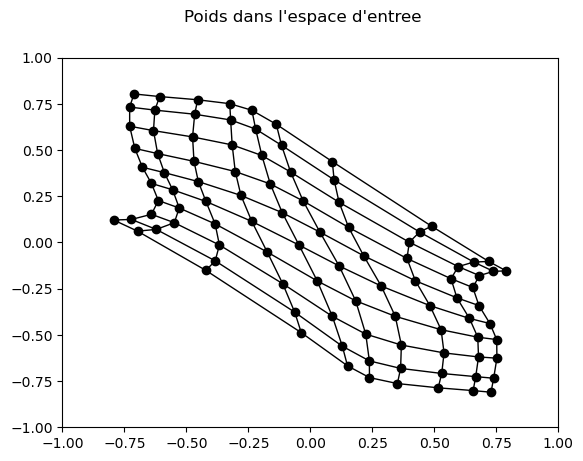

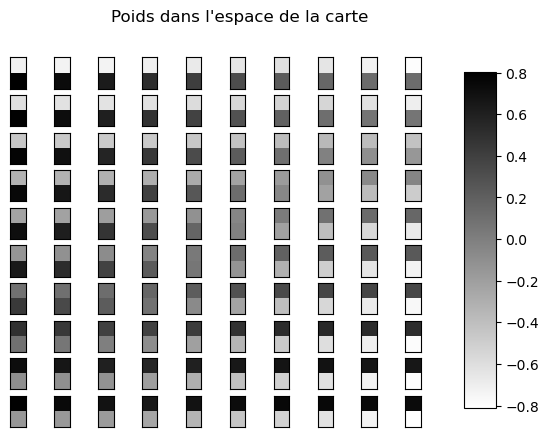

N: 40000
Erreur de quantification vectorielle moyenne: 0.013136378480468005
Distorsion locale moyenne: 0.029214994586348967
Rugosité locale moyenne: 0.029214994586348957


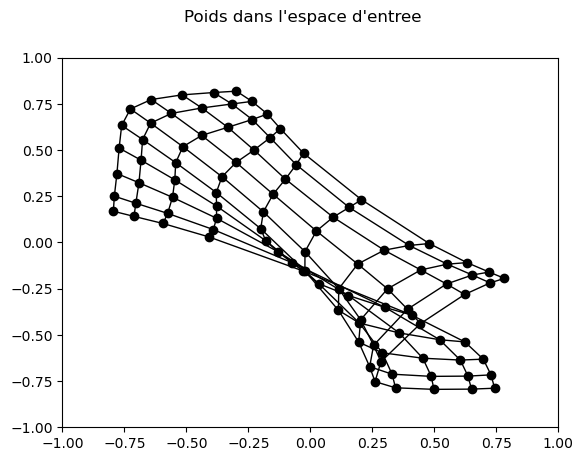

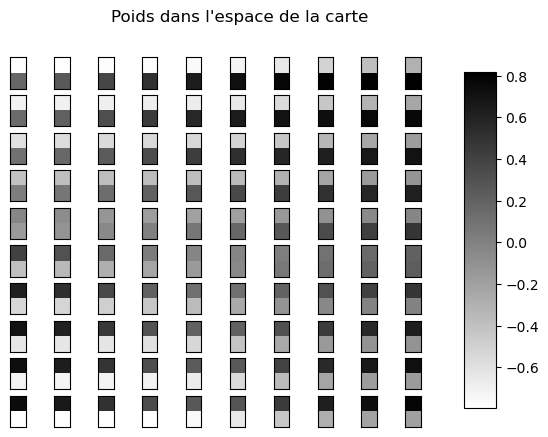

N: 50000
Erreur de quantification vectorielle moyenne: 0.013764734959146303
Distorsion locale moyenne: 0.0291123701783243
Rugosité locale moyenne: 0.02911237017832429


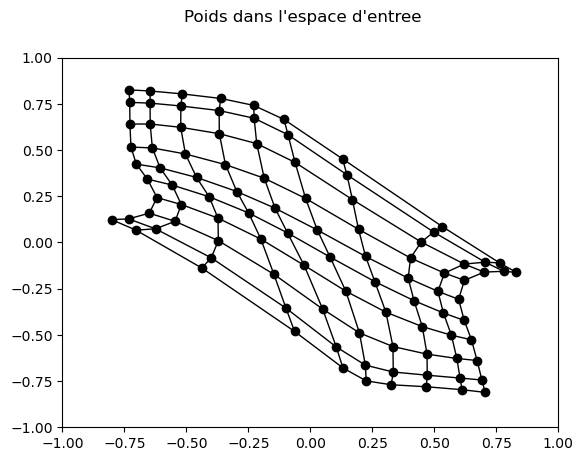

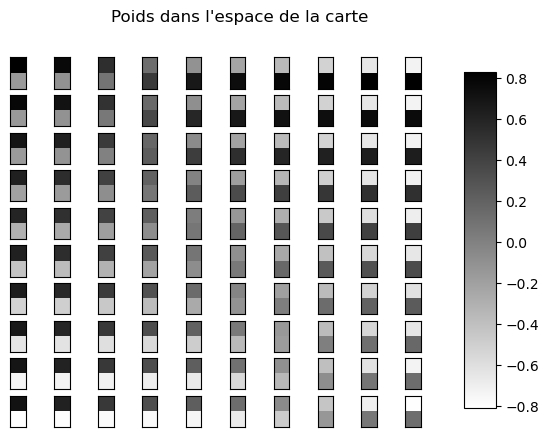

N: 70000
Erreur de quantification vectorielle moyenne: 0.013060639399573843
Distorsion locale moyenne: 0.029543391280835527
Rugosité locale moyenne: 0.02954339128083555


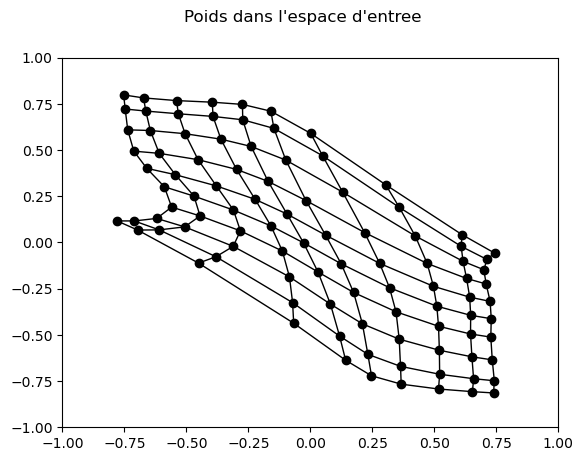

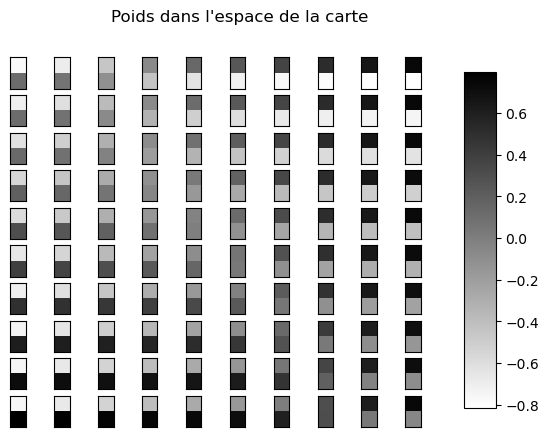

N: 100000
Erreur de quantification vectorielle moyenne: 0.012949476458386767
Distorsion locale moyenne: 0.02915189019628076
Rugosité locale moyenne: 0.029151890196280707


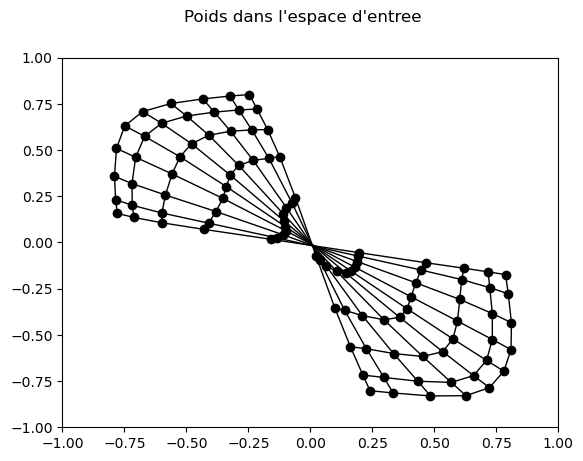

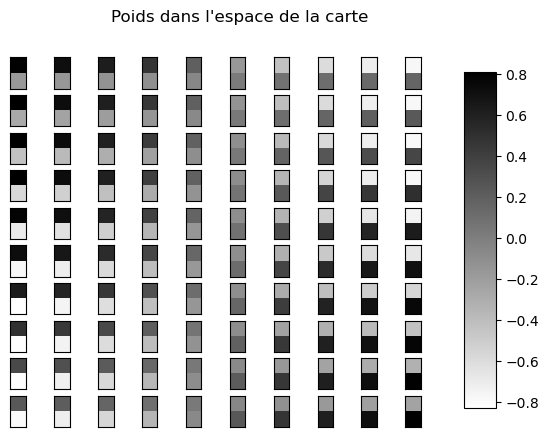

N: 200000
Erreur de quantification vectorielle moyenne: 0.01283543266703577
Distorsion locale moyenne: 0.02896699149583486
Rugosité locale moyenne: 0.0289669914958349


ValueError: x and y must have same first dimension, but have shapes (91,) and (7,)

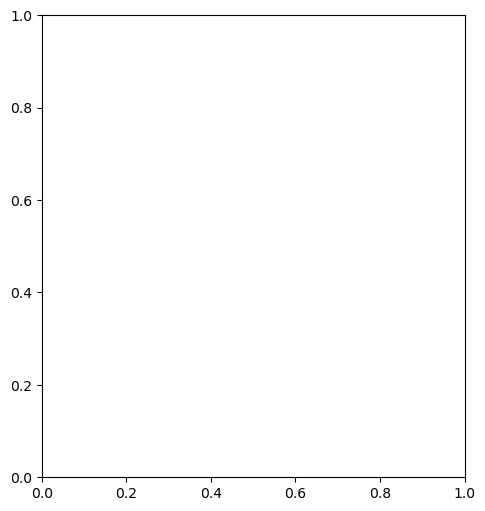

In [ ]:
# Iterate over sigma values from 1 to 10 with an increment of 0.1
final_soms = {}
samples1 = numpy.random.random((nsamples//2,2,1))
samples1[:,0,:] -= 1
samples2 = numpy.random.random((nsamples//2,2,1))
samples2[:,1,:] -= 1
samples = numpy.concatenate((samples1,samples2))

# Create a directory to save the results
directory = "SOM_results with varying N"
if not os.path.exists(directory):
    os.makedirs(directory)

quantification_errors = []
licompute_local_roughness = []
for N in [20000, 30000, 40000, 50000, 70000, 100000, 200000]:  # Different values of N
    # Create a new SOM for the current N
    som = SOM((2, 1), (10, 10))
    
    # Train the SOM
    for i in range(N + 1):
        index = numpy.random.randint(nsamples)
        x = samples[index].flatten()
        som.compute(x)
        som.learn(ETA, SIGMA, x)
    
    # Store the trained SOM
    final_soms[N] = som

    # Plot the final SOM
    som.scatter_plot(False)
    som.plot()
    print(f"N: {N}")
    print("Erreur de quantification vectorielle moyenne:", som.quantification(samples))
    quantification_errors.append(som.quantification(samples))
    print("Distorsion locale moyenne:", distorsion_locale_moyenne(som))
    print("Rugosité locale moyenne:", compute_local_roughness(numpy.array(som.weightsmap)))
    licompute_local_roughness.append(compute_local_roughness(numpy.array(som.weightsmap)))



Quantification errors: [0.011976640935097059, 0.014242647751709707, 0.013136378480468005, 0.013764734959146303, 0.013060639399573843, 0.012949476458386767, 0.01283543266703577]
Local roughness: [0.029473593206574587, 0.027813707400005418, 0.029214994586348957, 0.02911237017832429, 0.02954339128083555, 0.029151890196280707, 0.0289669914958349]


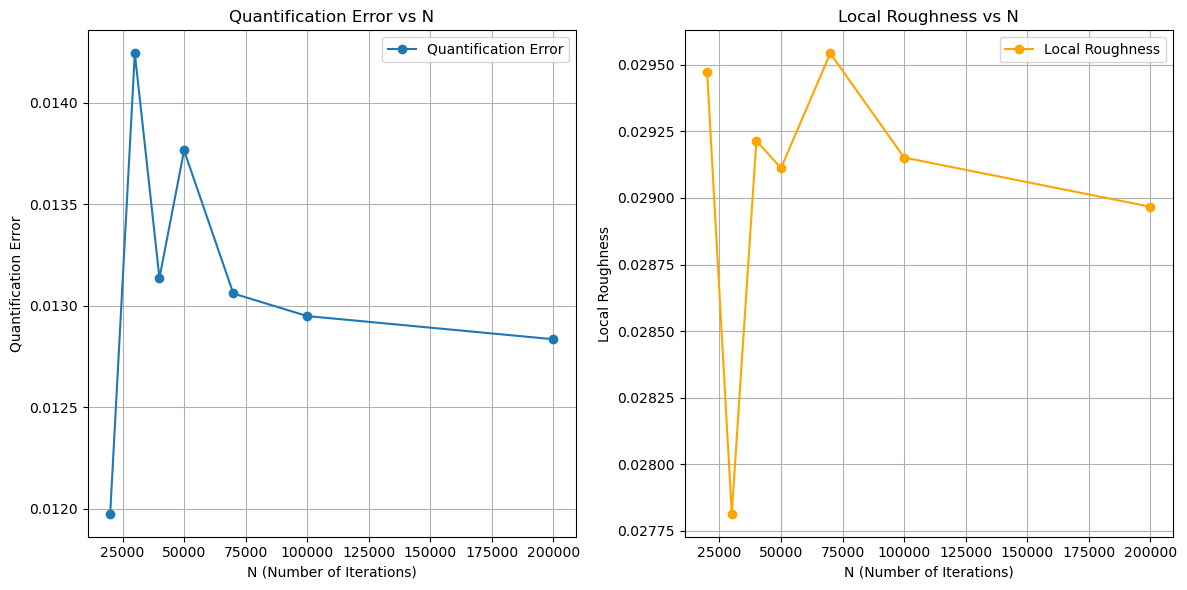

In [9]:
print("Quantification errors:", quantification_errors)
print("Local roughness:", licompute_local_roughness)

# Save the results to a file
with open(os.path.join(directory, "resultats nombre iterations.txt"), "w") as f:
    f.write("N\tQuantification Error\tLocal Roughness\n")
    for N, error, roughness in zip(final_soms.keys(), quantification_errors, licompute_local_roughness):
        f.write(f"{N}\t{error}\t{roughness}\n")

        
# Plot quantification errors and local roughness as a function of N
import matplotlib.pyplot as plt

N_values = list(final_soms.keys())

plt.figure(figsize=(12, 6))

# Plot quantification errors
plt.subplot(1, 2, 1)
plt.plot(N_values, quantification_errors, marker='o', label='Quantification Error')
plt.xlabel('N (Number of Iterations)')
plt.ylabel('Quantification Error')
plt.title('Quantification Error vs N')
plt.grid(True)
plt.legend()

# Plot local roughness
plt.subplot(1, 2, 2)
plt.plot(N_values, licompute_local_roughness, marker='o', color='orange', label='Local Roughness')
plt.xlabel('N (Number of Iterations)')
plt.ylabel('Local Roughness')
plt.title('Local Roughness vs N')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
